## Enhanced Deep Super Resolution
Using enhanced ResNet

In [1]:
# Imports

import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from models import resnet

from skimage.io import imread, imsave
from skimage.util import img_as_float


import dataset
import utils
import train

### Create the dataset objects for train and test datasets

In [2]:
patch_size = 96
num_patches = 20

train_dir = '/media/rstar000/A284238D842362D1/ML/datasets/DIV2K_train_HR/'
test_dir = '/media/rstar000/A284238D842362D1/ML/datasets/anime/'
train_ds = dataset.Div2KDataset(train_dir, patch_size, num_patches)
test_ds = dataset.Div2KDataset(test_dir, patch_size, num_patches)

In [3]:
# Verify that images load correctly
def test_data():
    for i in range(50):
        hr, lr = train_ds.__getitem__(i)
        hr = hr.cpu().numpy()
        lr = lr.cpu().numpy()
        hr = utils.restore_image(hr)
        lr = utils.restore_image(lr)

        utils.show_images([lr,hr])
        
#test_data()

In [4]:
def calc_stats(n):
    mean = 0
    std = 0
    for i in range(n):
        hr, lr = train_ds.__getitem__(i)
        hr = hr.cpu().numpy()
        hr = utils.restore_image(hr)
        
        cur_mean = hr.mean((0,1))
        cur_std = hr.std()
        
        mean += cur_mean
        std += cur_std
    return mean / n, std / n

In [5]:
train_loader = DataLoader(train_ds, batch_size=20, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=20, shuffle=False, num_workers=0)

### Create the network and optimizer

In [6]:
net = resnet.ResNet(32, 128)
net = net.cuda()

In [7]:
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.0001)
loss = torch.nn.L1Loss()

### Checkpoint functions

In [8]:
def save_model(filename):
    torch.save(net.state_dict(), 'checkpoints/' + filename)
    
def load_model(filename):
    net.load_state_dict(torch.load(filename))


In [9]:
load_model('checkpoints/2_0.bin')

### Start training

In [10]:
n_epochs = 15
for i in range(n_epochs):
    print('Epoch ', i, 'starts!')
    train.train_epoch(optimizer, net, train_loader, loss)
    save_model(str(i) + '.bin')

Epoch  0 starts!



Epoch  1 starts!



Epoch  2 starts!



Epoch  3 starts!



Epoch  4 starts!



Epoch  5 starts!


KeyboardInterrupt: 

In [11]:
save_model('2_1.bin')

### Test the model on the testing dataset

In [12]:
def test():
    x = test_ds.__getitem__(0)
    hr, lr = x

    lr_np = lr.cpu().numpy()
    lr_np = utils.restore_image(lr_np)

    lr = lr.unsqueeze(0).cuda()
    res = net(Variable(lr))

    res = res.data[0].cpu().numpy()
    res = utils.restore_image(res)
    res = np.clip(res, 0,1)

    hr = hr.cpu().numpy()
    hr = utils.restore_image(hr)

    utils.show_images([lr_np, res, hr])

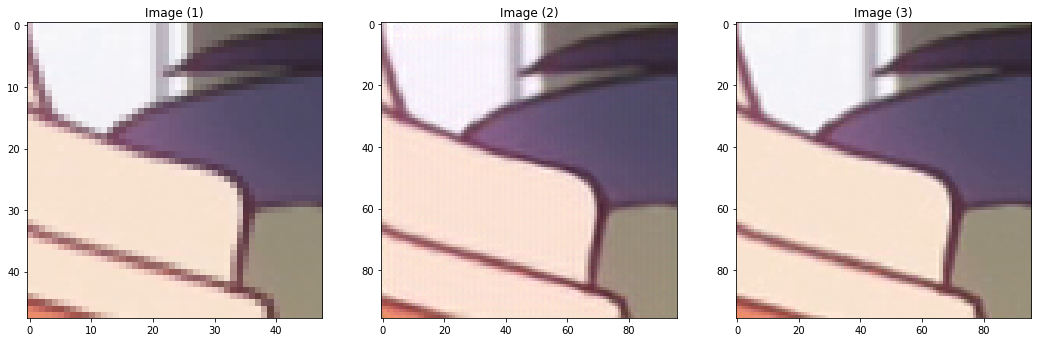

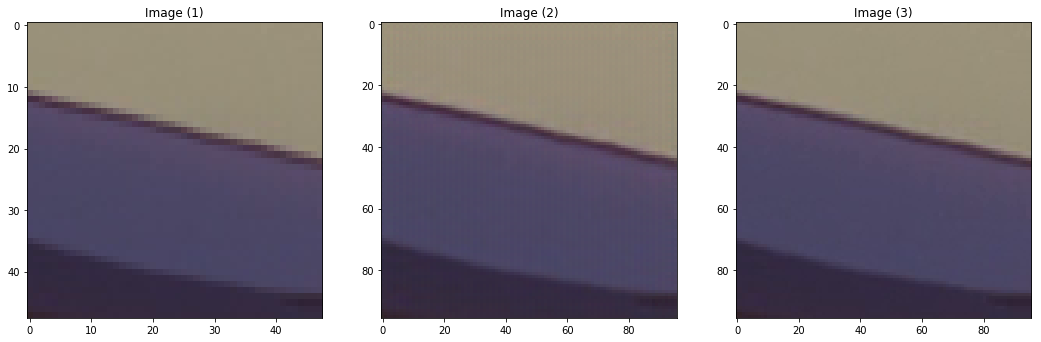

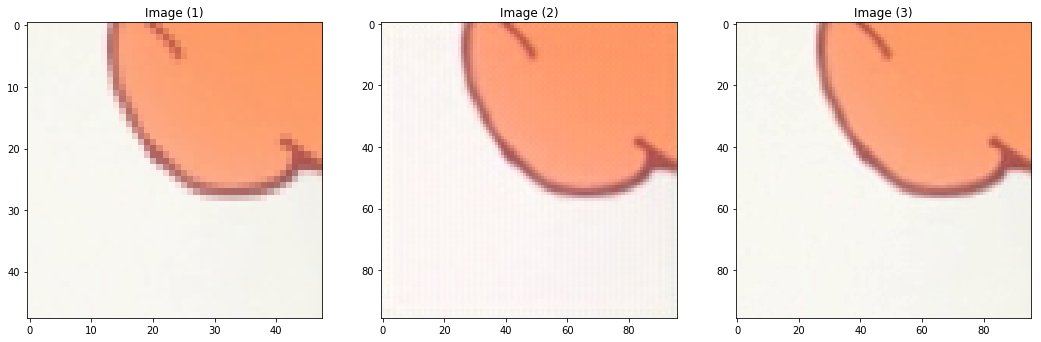

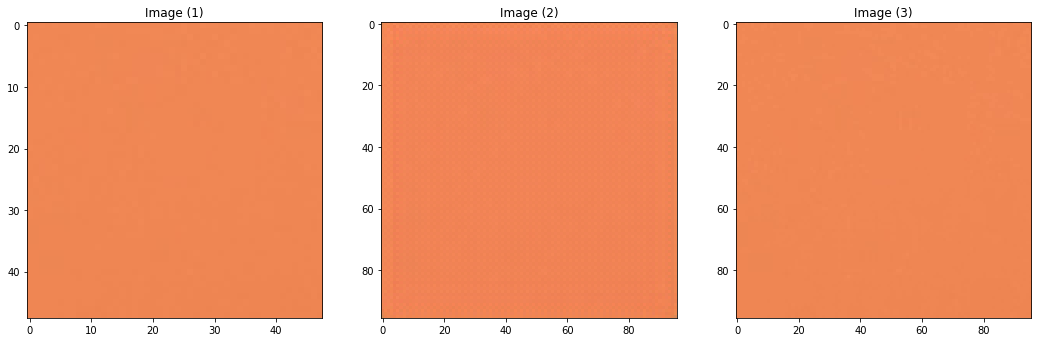

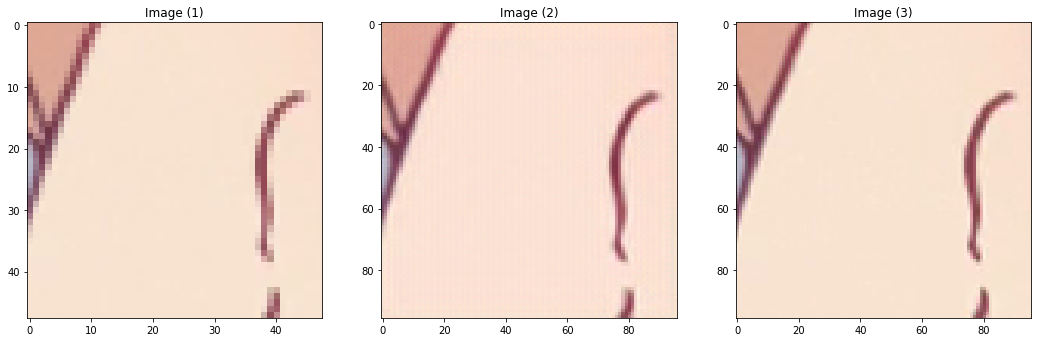

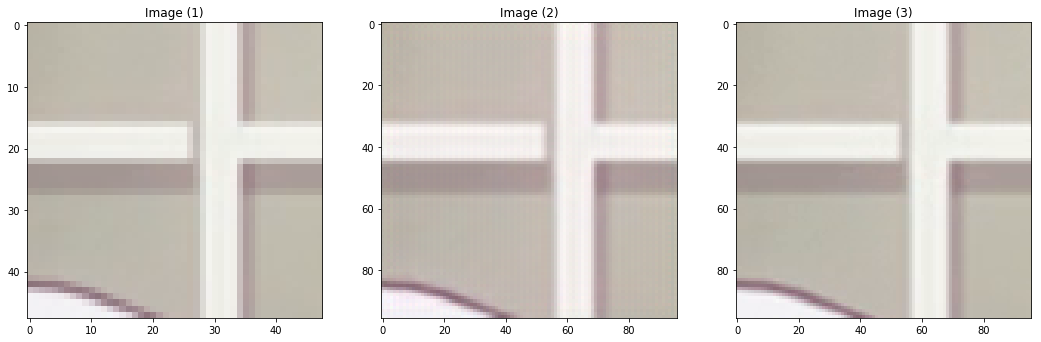

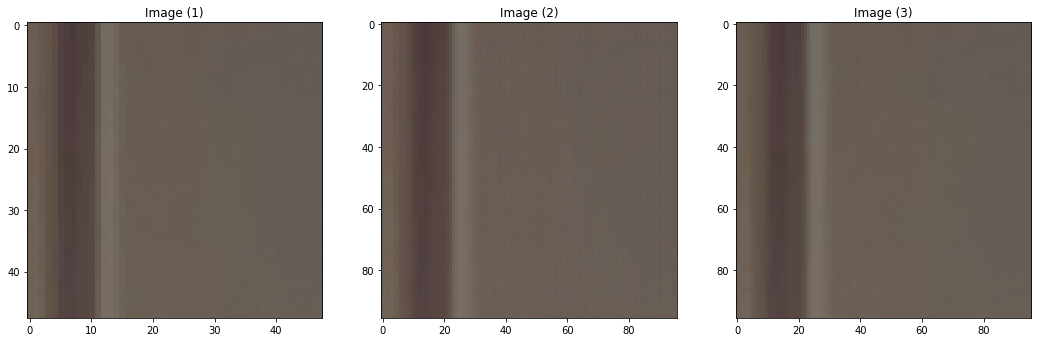

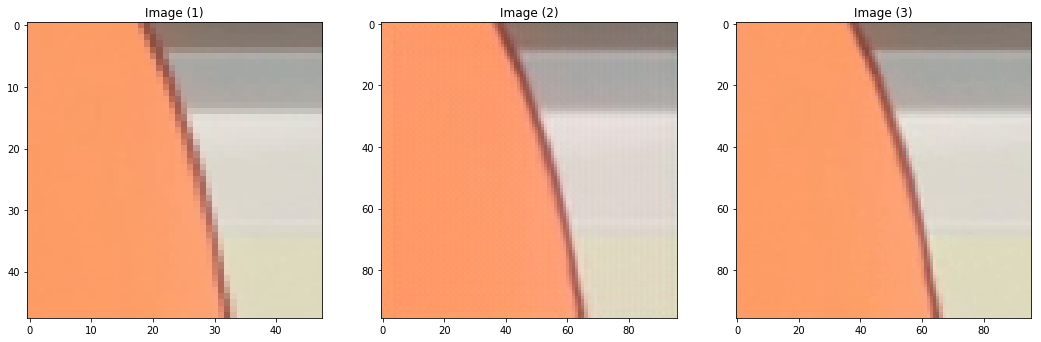

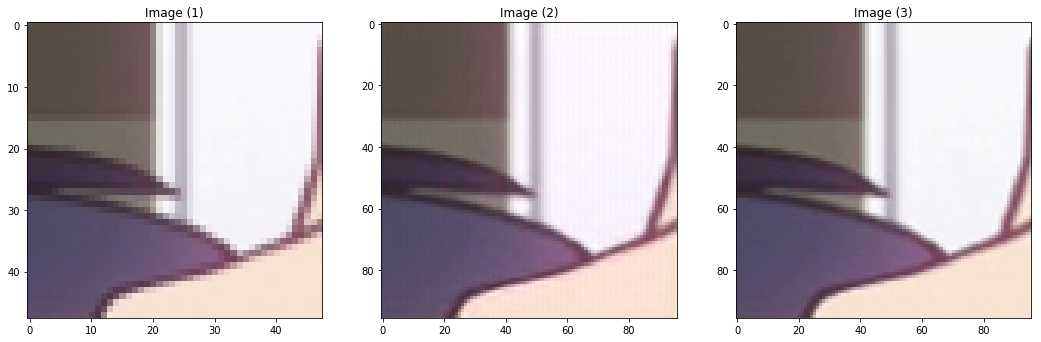

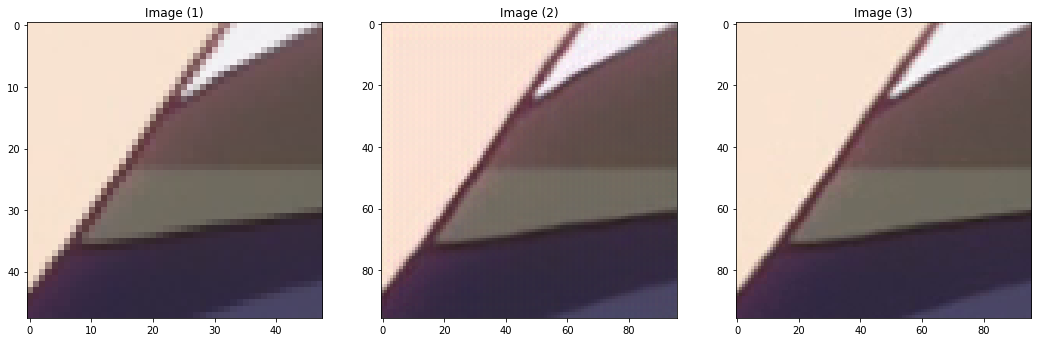

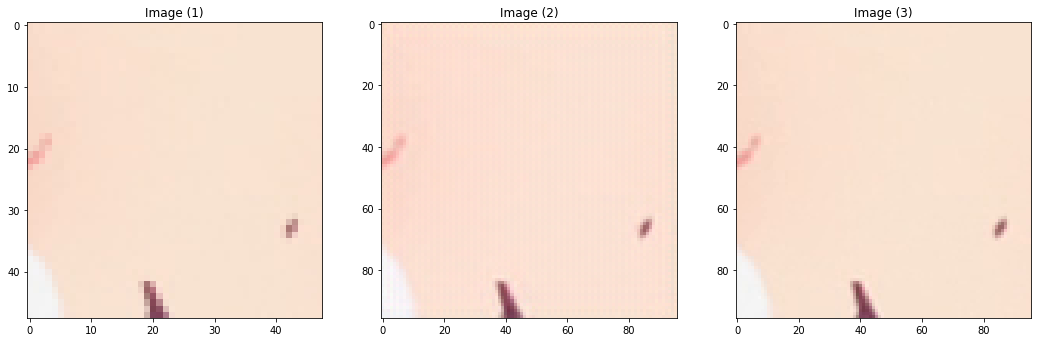

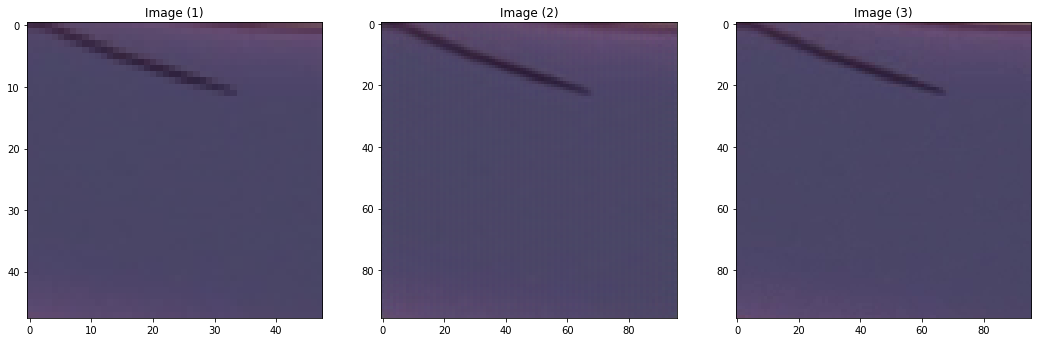

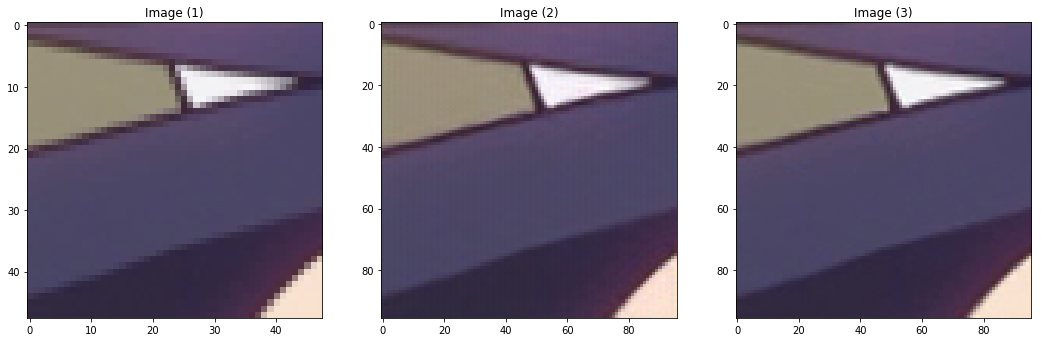

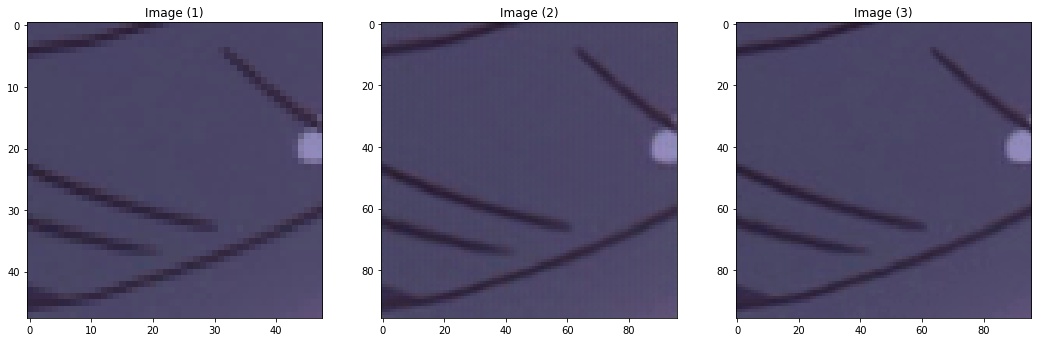

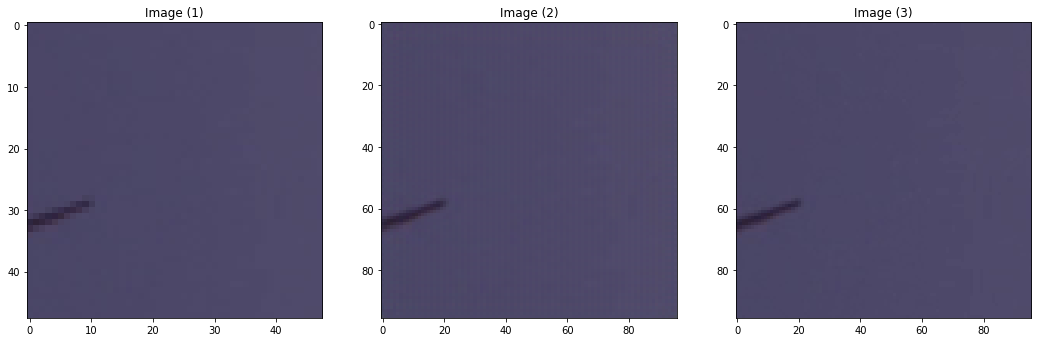

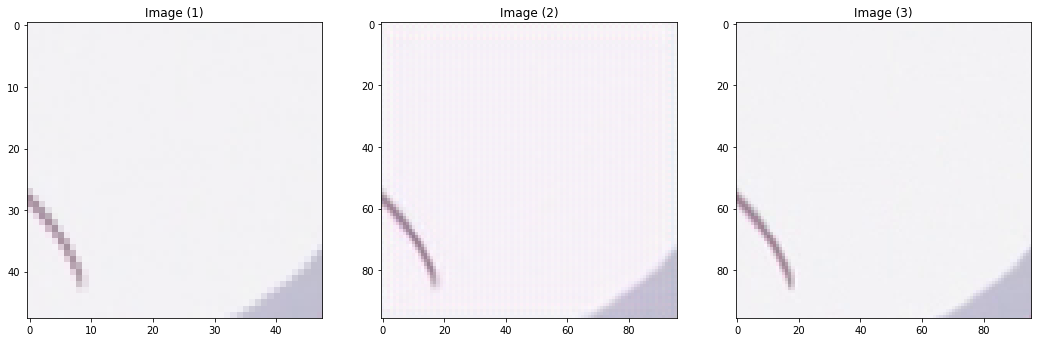

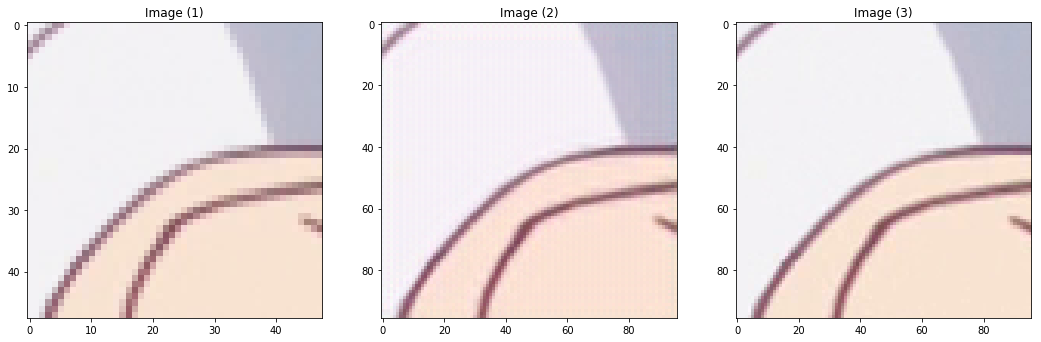

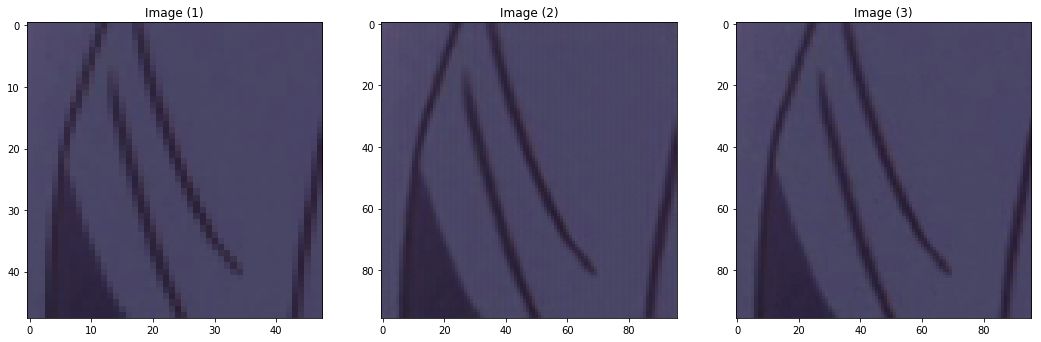

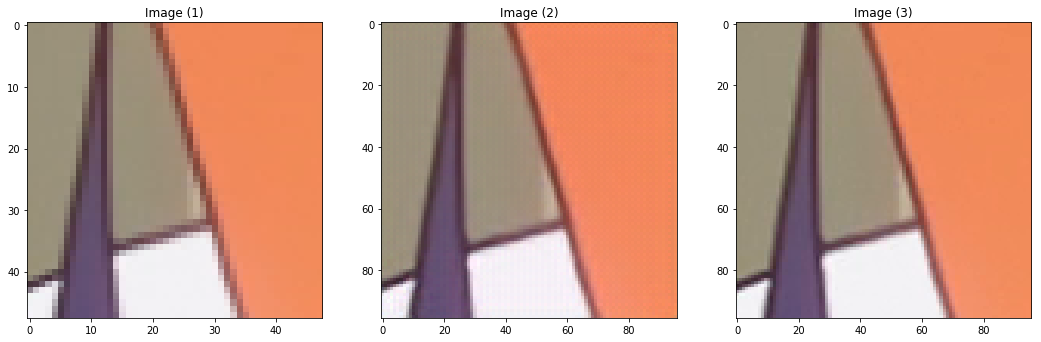

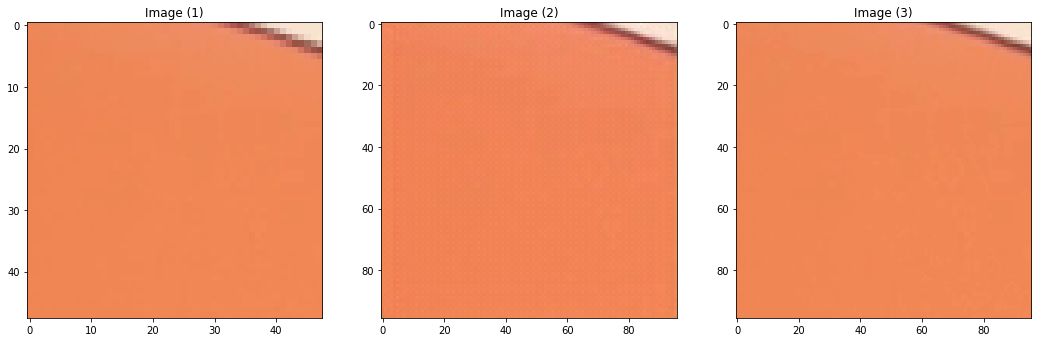

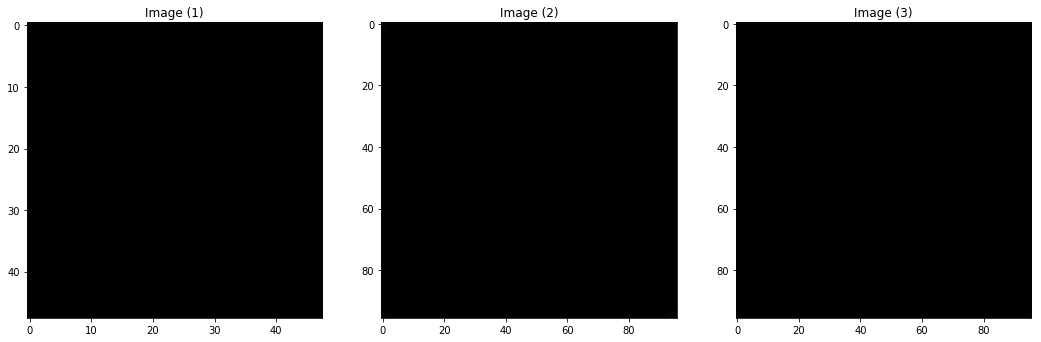

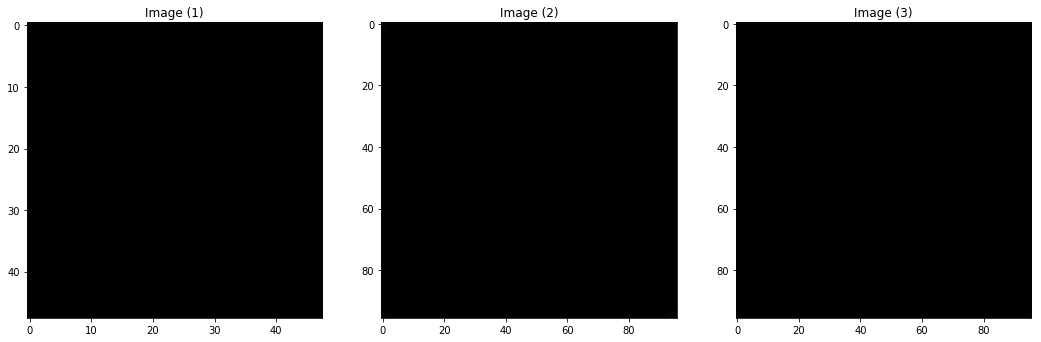

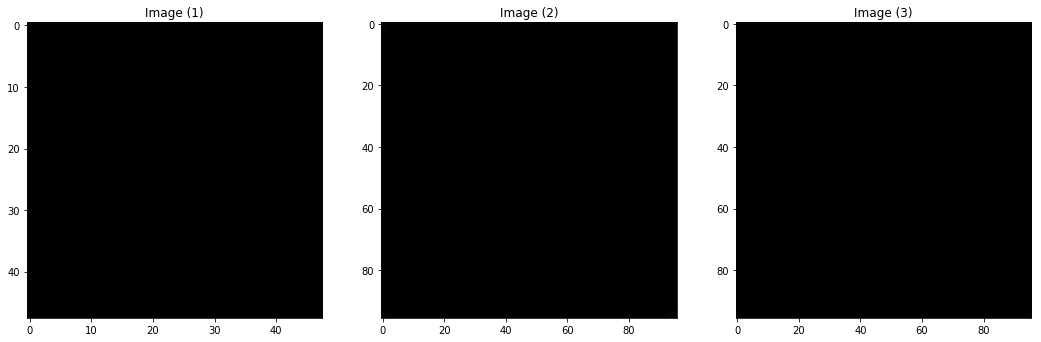

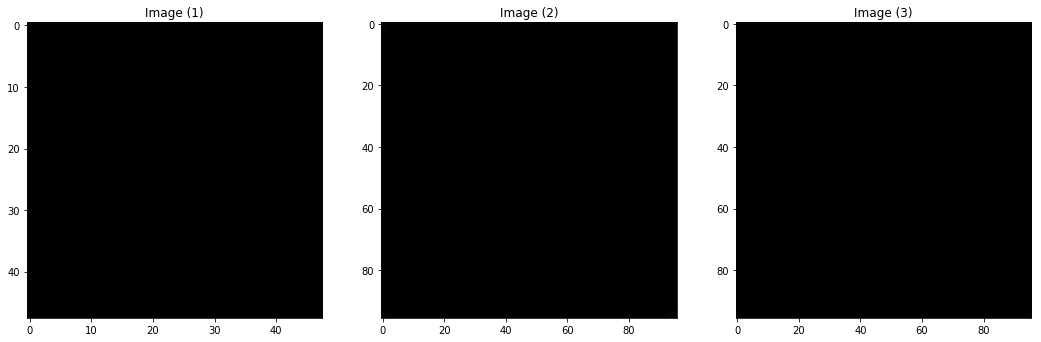

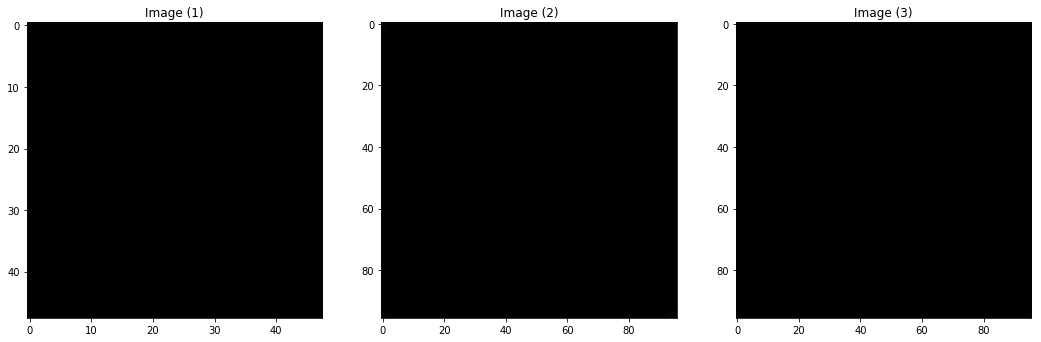

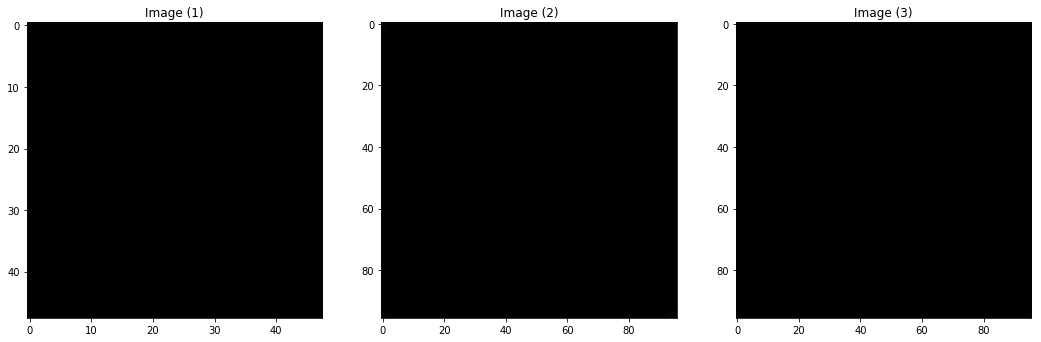

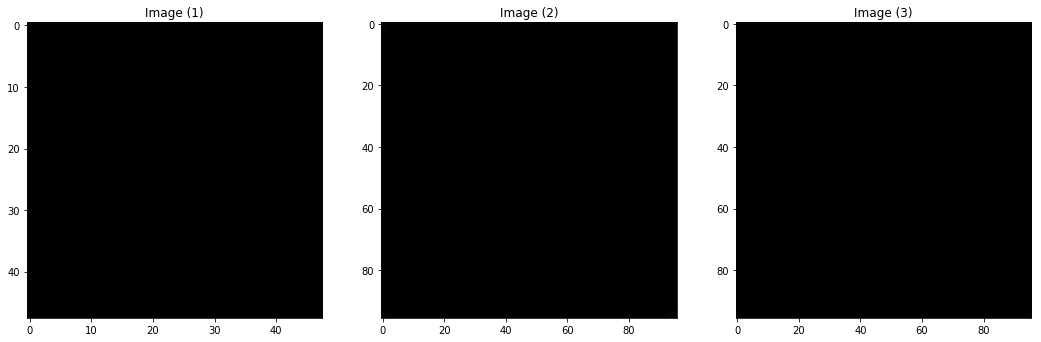

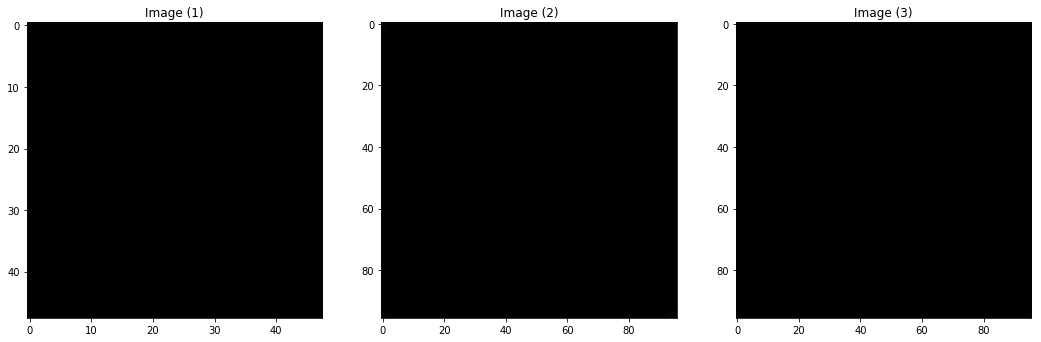

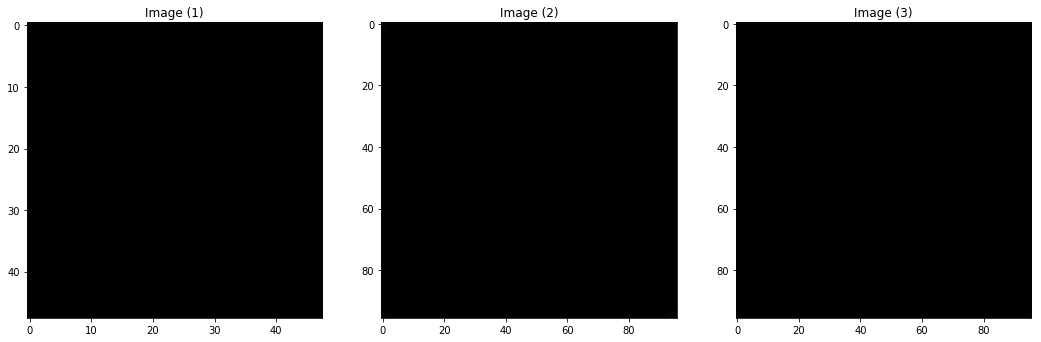

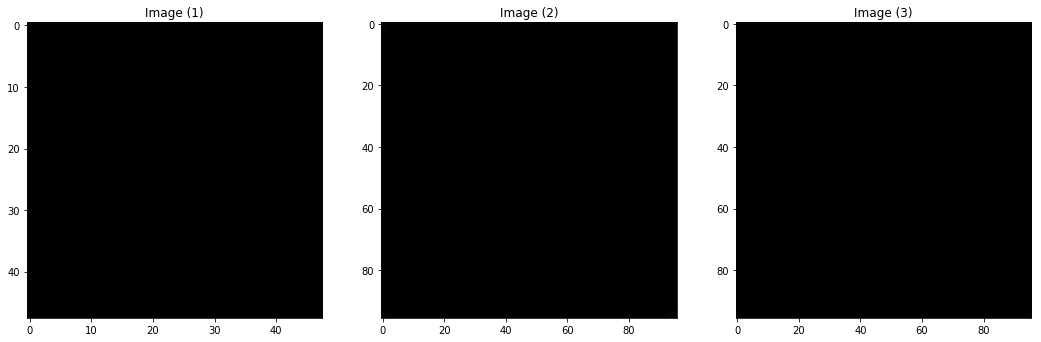

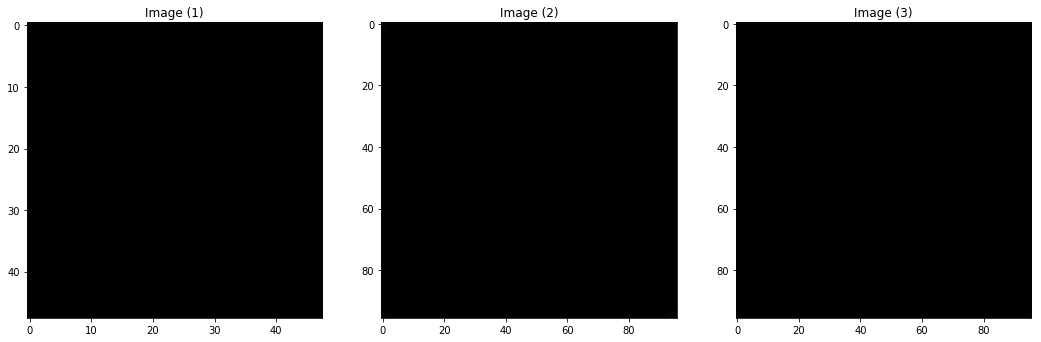

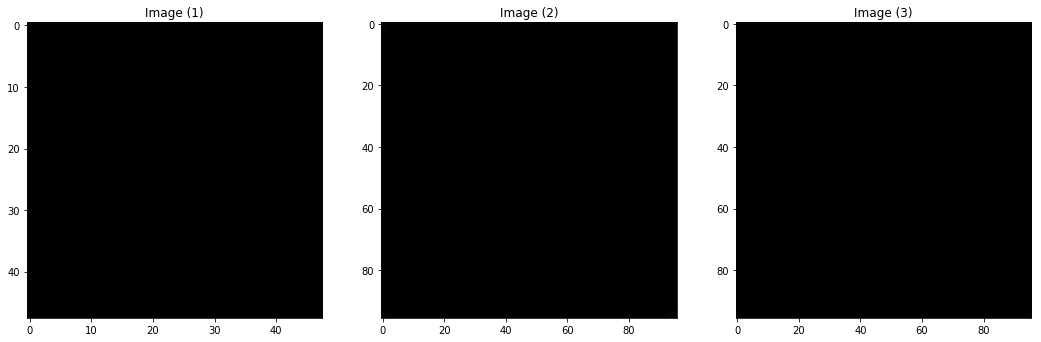

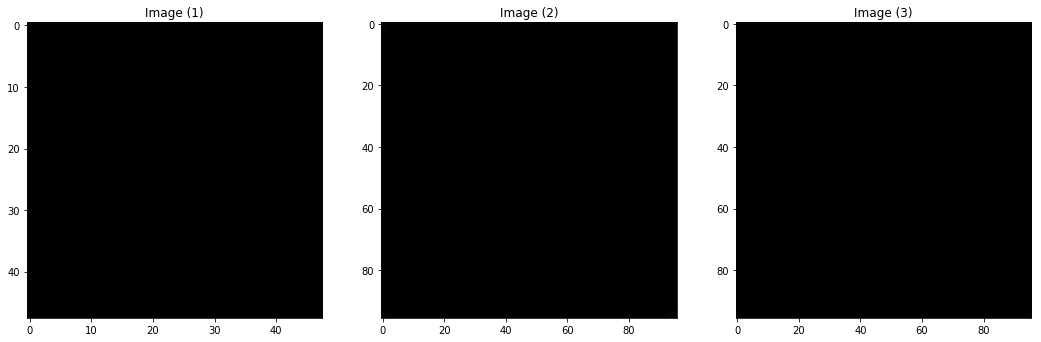

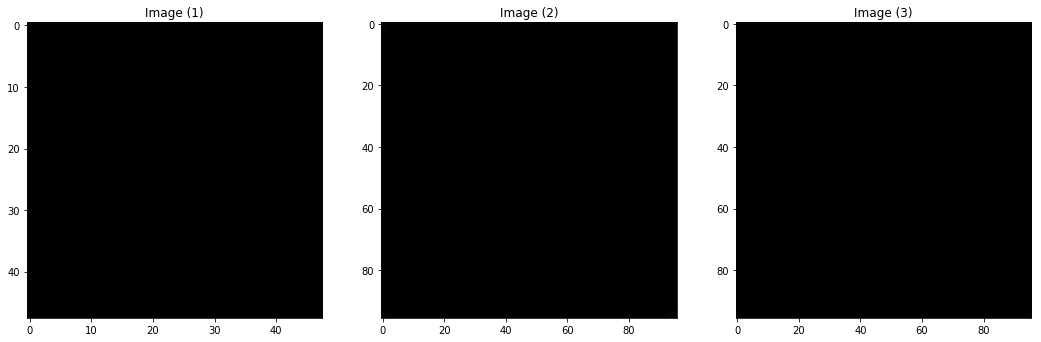

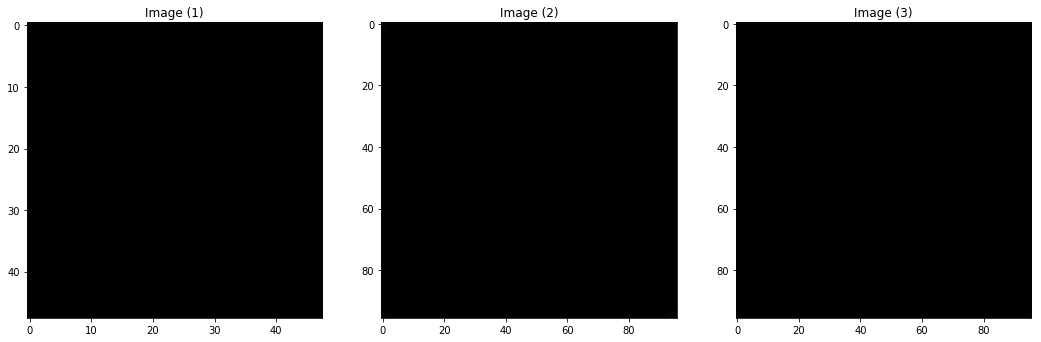

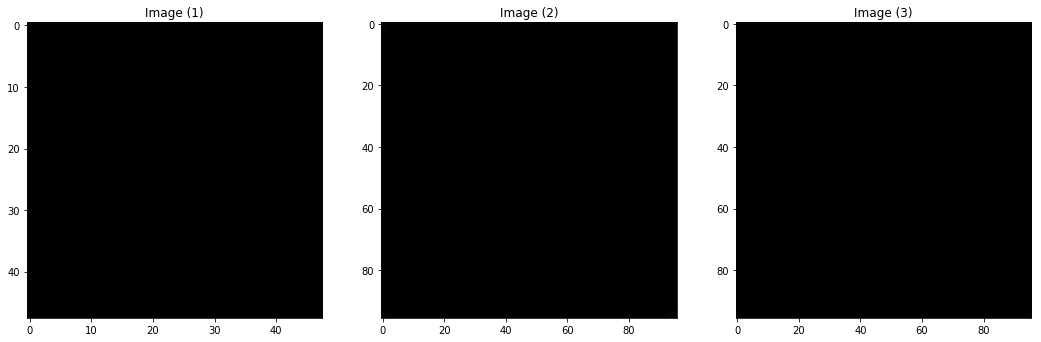

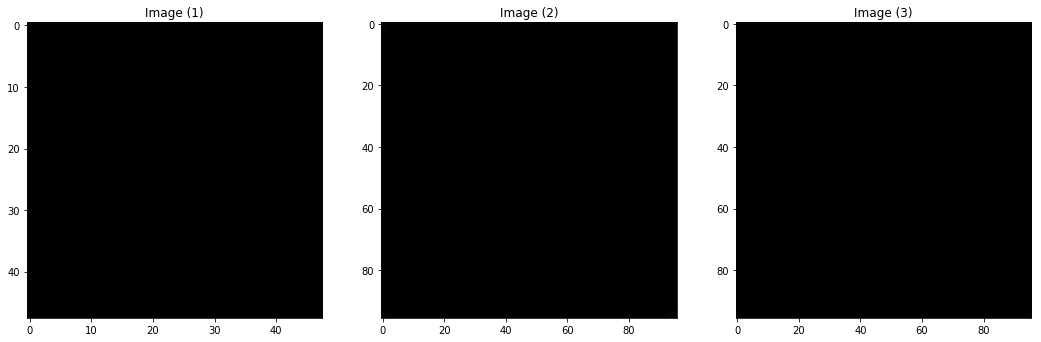

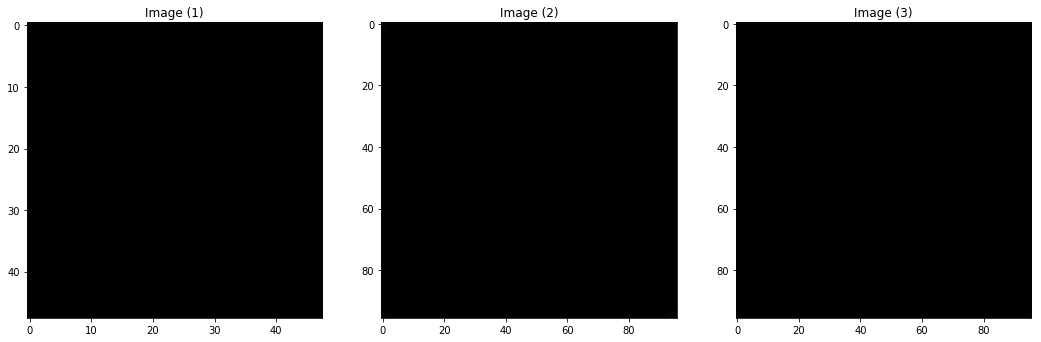

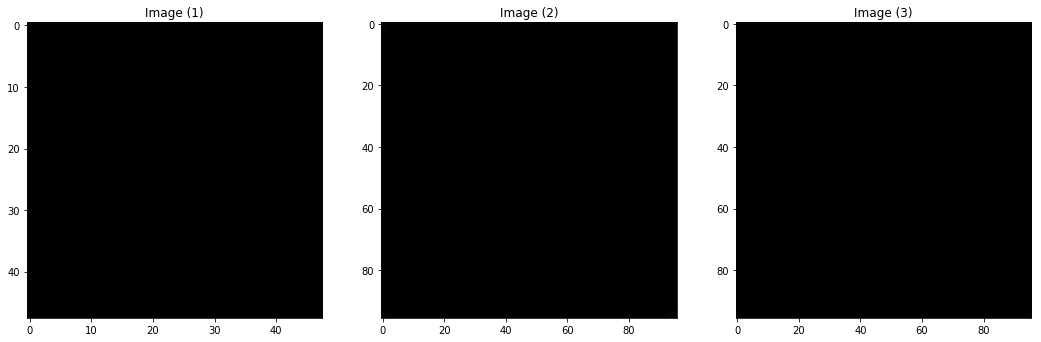

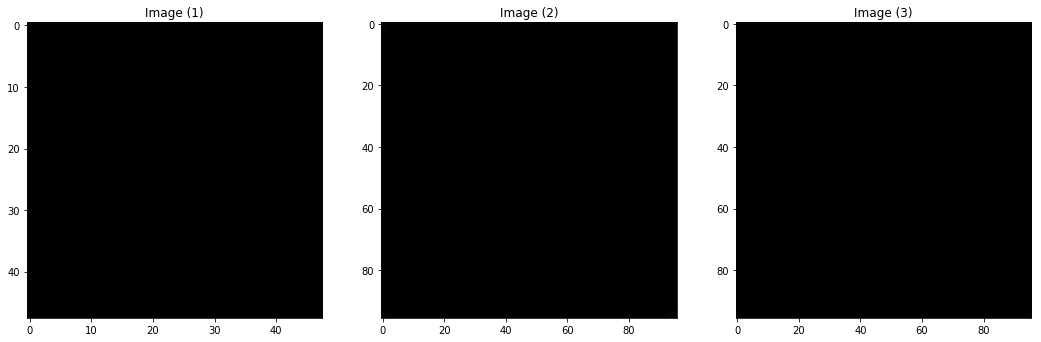

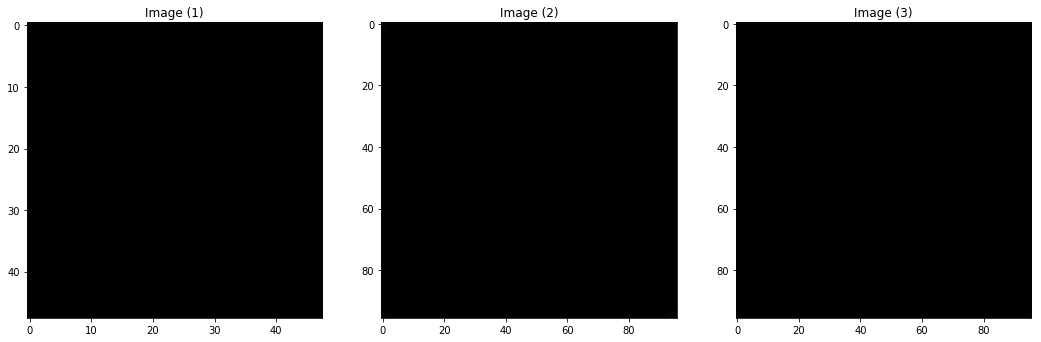

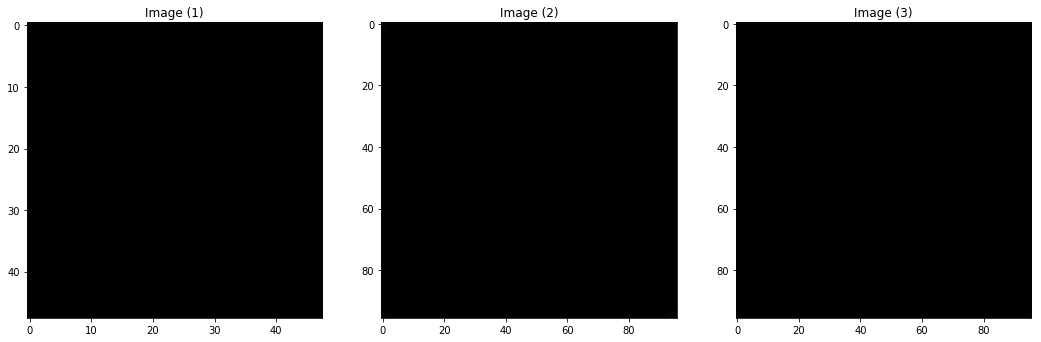

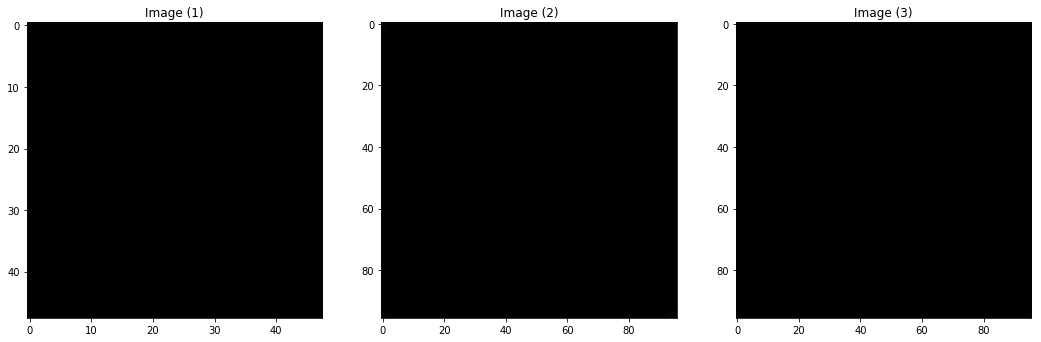

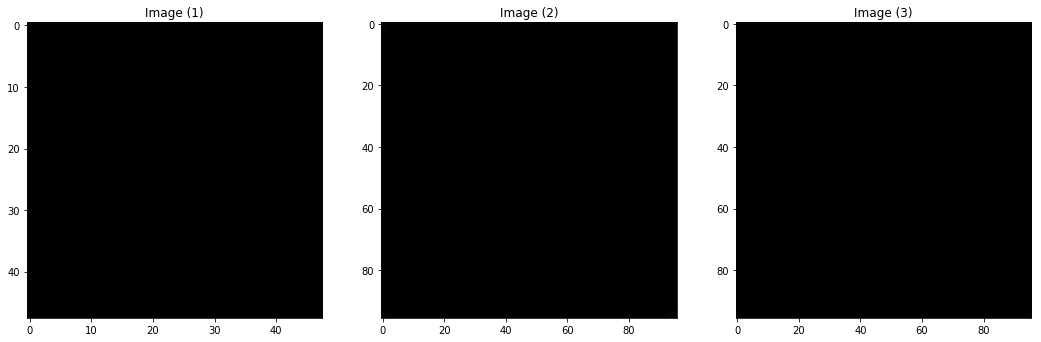

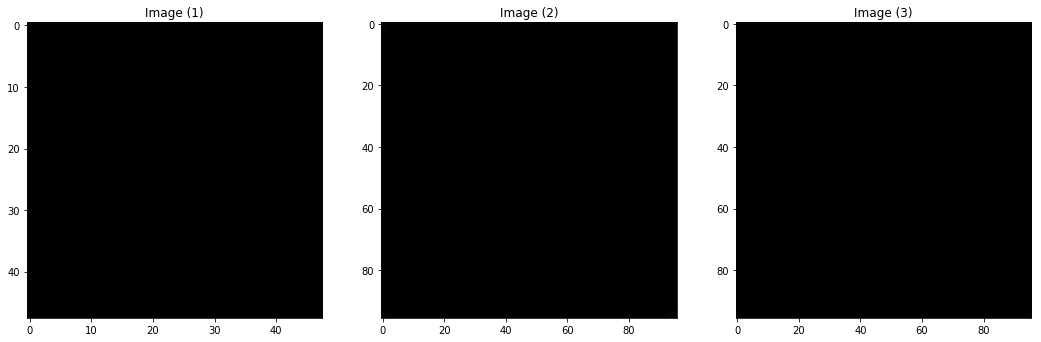

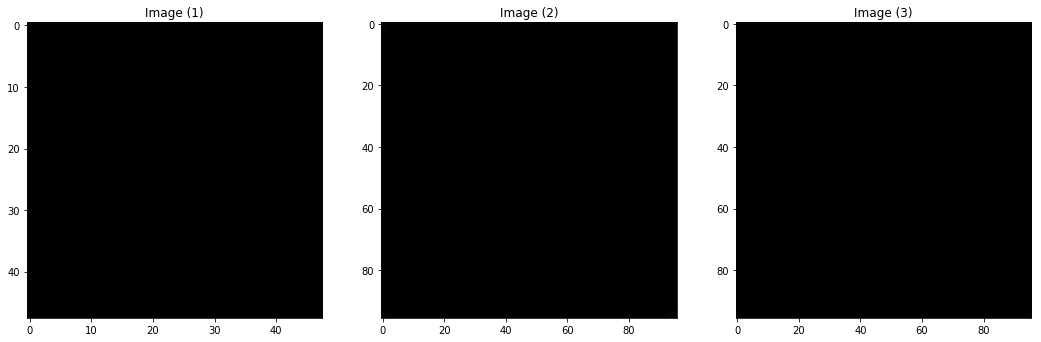

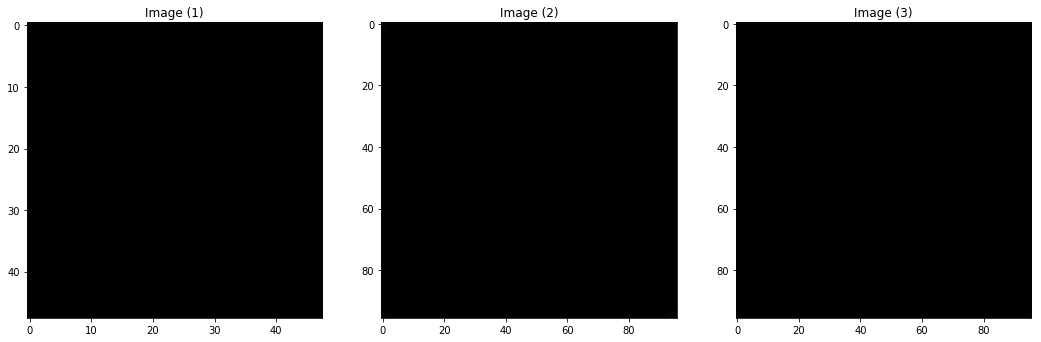

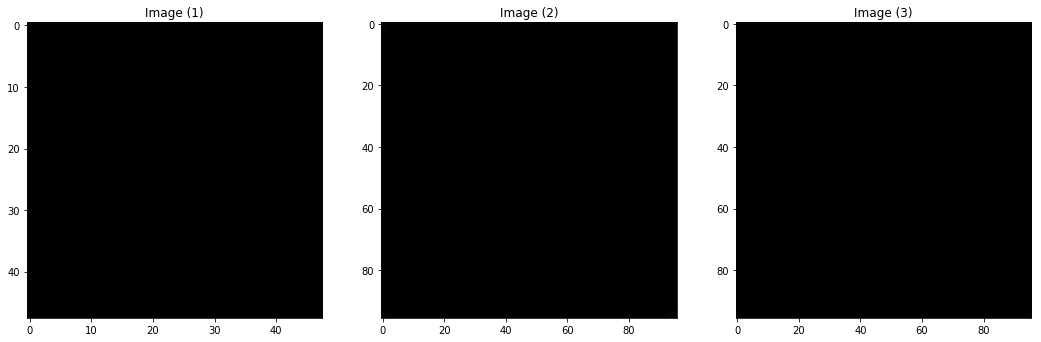

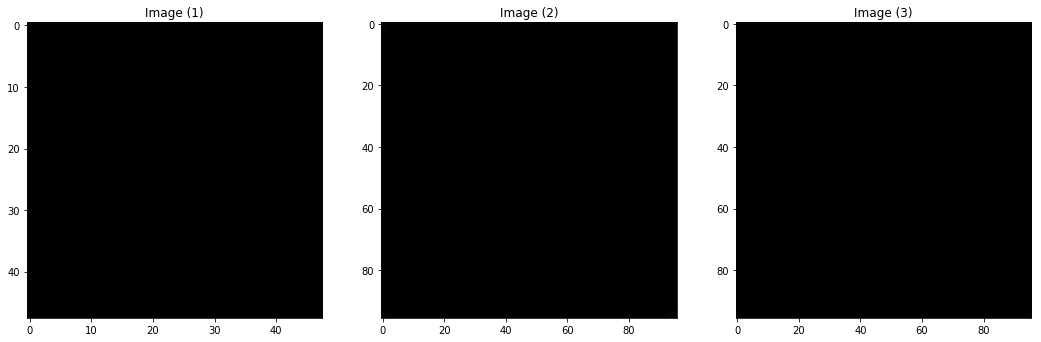

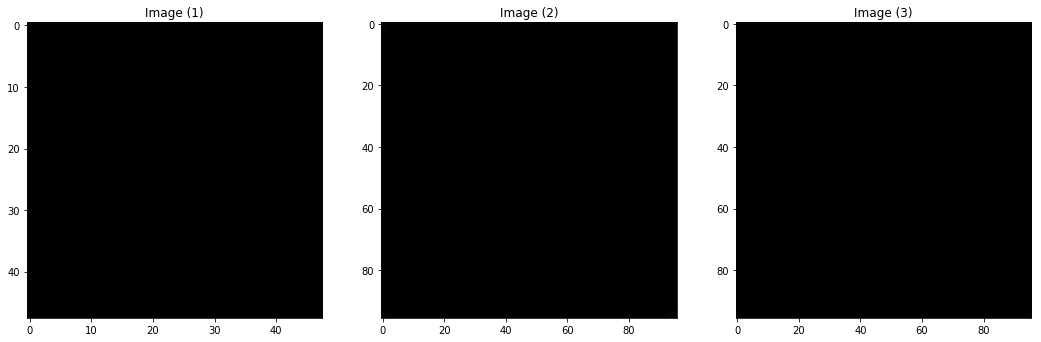

In [13]:
for i in range(50):
    test()

### Test the model on real images!

In [ ]:
def test_img(filename):
    img = imread(filename)
    hr = img.copy()
    img = utils.preprocess_image(img)
    img = np.expand_dims(img, 0)
    img = img.astype(np.float32)
    x = torch.from_numpy(img).cuda()
    x = Variable(x)
    y = net(x)
    y = y.data[0]
    y = y.cpu().numpy()
    print(y)

In [ ]:
test_img('tests/2.jpg')